# KeyVR dataset explorer

In [1]:
!pip install torch torchvision mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 51.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 56.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 KB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 68.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 KB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 KB 13.0 MB/s eta 0:00:0

## Torch dataset and utils

In [10]:
import torch
import torch.utils
import torch.utils.data
import pandas as pd
import torchvision
import torchvision.transforms.functional
import torchvision.transforms.v2 as v2
import numpy as np
import os

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
%matplotlib inline
from IPython.display import HTML

def display_video(video_tensor):
    """
    Display video from PyTorch tensor with shape (frames, height, width, channels)
    Video values should be in range 0-255
    
    Parameters:
        video_tensor: PyTorch tensor of shape (frames, height, width, channels)
    """
    # Convert tensor to numpy and normalize to 0-1 range
    video_normalized = video_tensor.cpu().numpy() / 255.0
    
    fig = plt.figure(figsize=(8, 4))
    im = plt.imshow(video_normalized[0])
    plt.axis('off')
    
    def animate(i):
        im.set_data(video_normalized[i])
        return [im]
    
    anim = animation.FuncAnimation(
        fig, 
        animate, 
        frames=len(video_normalized),
        interval=500,  # Time between frames in milliseconds
        blit=True
    )
    
    return HTML(anim.to_jshtml())


clf_id2label = ['comma', 'dot', 'delete', 'space',
                         'a', 'b', 'c', 'd',
                         'e', 'f', 'g', 'h',
                         'i', 'j', 'k', 'l',
                         'm', 'n', 'o', 'p',
                         'q', 'r', 's', 't',
                         'u', 'v', 'w', 'x',
                         'y', 'z']

clf_label2id = {
    'comma': 0, 'dot': 1, 'delete': 2, 'space': 3,
    'a': 4, 'b': 5, 'c': 6, 'd': 7,
            'e': 8, 'f': 9, 'g': 10, 'h': 11,
            'i': 12, 'j': 13,  'k': 14, 'l': 15,
            'm': 16, 'n': 17, 'o': 18, 'p': 19,
            'q': 20, 'r': 21, 's': 22, 't': 23,
            'u': 24, 'v': 25, 'w': 26, 'x': 27,
            'y': 28, 'z': 29
}

detect_id2label = ['idle', 'active']
detect_label2id = {'idle': 0, 'active': 1}

#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(detection_result, rgb_img, mode):
  if mode == 'image':
    annotated_image = np.copy(rgb_img)
    return torch.from_numpy(annotated_image)
  elif mode == 'skeleton':
    annotated_image = np.zeros_like(rgb_img)
  elif mode == 'image_and_skeleton':
    annotated_image = np.copy(rgb_img)

  # Loop through the detected hands to visualize.
  for idx in range(len(detection_result)):
    hand_landmarks = detection_result[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark[0], y=landmark[1], z=landmark[2]) for landmark in hand_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

  return torch.from_numpy(annotated_image)

class BaseStreamDataset(torch.utils.data.Dataset):
    def __init__(self, *args, **kwargs): pass

    @classmethod
    def create_dataset(cls, video_path: str, landmark_path:str, label_path: str,
                       gap: int, f_before: int = 3, f_after: int = 4, delay: int = 10):
        if gap:
            return KeyDetectDataset(
                video_path=video_path,
                label_path=label_path,
                landmark_path=landmark_path,
                gap=gap,
                f_after=f_after,
                f_before=f_before,
                delay=delay)
        
        return KeyClfStreamDataset(
            video_path=video_path,
            label_path=label_path,
            landmark_path=landmark_path,
            f_after=f_after,
            f_before=f_before,
            delay=delay)

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        (start, end), label = self.segments[idx]
        
        frames = self.video[start: end+1]
        frames = frames.permute(3, 0, 2, 1) # permute to channels, frames, points, hands

        return frames.float(), self.label2id[label]

    def get_class_counts(self):
        labels = np.array([segment[1] for segment in self.segments])

        counts = []
        for label in self.id2label:
            count = np.sum(labels == label)
            counts.append(count)

        df = pd.DataFrame({'label': self.id2label, 'count': counts})
        return df

    def create_segment(self, idx, dest_folder=None, format='mp4', fps=3.0, mode='image'):
        (start, end), label = self.segments[idx]
       

        annotated = []
        

        for idx in range(start, end+1):
            lm = self.video[idx]
            if mode == 'image' or mode == 'image_and_skeleton':
                img = torchvision.io.image.read_image(f"{self.video_path}/frame_{idx}.jpg").permute(1, 2, 0).numpy()
            else:
                img = np.zeros(shape=[480, 480, 3])
            annotated.append(draw_landmarks_on_image(
                lm.numpy(), 
                img,
                mode=mode
            ))
        annotated = torch.stack(annotated)
        
        if format:
            if not os.path.exists(f'{dest_folder}/segments_{format}'):
                os.makedirs(f'{dest_folder}/segments_{format}')
            video_name = f'{dest_folder}/segments_{format}/{self.video_name}_{label}_f{start}_{end}.{format}'
            torchvision.io.video.write_video(
                filename=video_name, 
                video_array=annotated, 
                fps=fps
            )
        else:
            return annotated, label
class KeyClfStreamDataset(BaseStreamDataset):
    def __init__(self,
                 video_path: str,
                 label_path: str,
                 landmark_path: str,
                 f_before=3,
                 f_after=4,
                 delay=4,
                 transforms=None):

        self.video_path = video_path
        self.landmark_path = landmark_path
        self.video_name = video_path.split('/')[-1]
        self.data_dir = video_path.split('/')[-3]
        self.transforms = transforms
        self.id2label = clf_id2label
        self.label2id = clf_label2id
        self.video = torch.load(self.landmark_path, weights_only=True)
        df = pd.read_csv(label_path)

        if not df['Frame'].is_unique:
            duplicated = df['Frame'].duplicated(keep=False)
            # print(f"Duplicate segment found {len(duplicated)}/ {len(df)}")
            # print(df[duplicated])
            df = df[~df['Frame'].duplicated()]
        
        segments = []
        total = f_after + f_before + 1
        last_frame = len(self.video) - 1
        for index, row in df.iterrows():
            key_value = row['Key']  # Key pressed
            # Frame number where key was pressed
            key_frame = int(row['Frame']) + delay

            if key_value not in self.id2label:
                continue

            pos_start, pos_end = max(key_frame - f_before, 0), min(key_frame + f_after, last_frame)
            
            if (pos_end - pos_start + 1) == total:
                segments.append(([pos_start, pos_end], key_value))
        self.segments = segments


class KeyDetectDataset(BaseStreamDataset):
    def __init__(self,
                 video_path: str,
                 label_path: str,
                 landmark_path: str,
                 gap,
                 f_before=3,
                 f_after=4,
                 delay=4):

        self.video_path = video_path
        self.landmark_path = landmark_path
        self.video_name = video_path.split('/')[-1]
        self.data_dir = video_path.split('/')[-3]
        self.video = torch.load(self.landmark_path, weights_only=True)
        df = pd.read_csv(label_path)
        total_window = f_before + f_after + 1

        segments = []

        self.id2label = detect_id2label
        self.label2id = detect_label2id
        
        last_frame = len(self.video) - 1
        for index, row in df.iterrows():
            # Frame number where key was pressed
            key_frame = int(row['Frame']) + delay
            key_value = row['Key']  # Key pressed

            pos_start, pos_end = max(key_frame - f_before, 0), min(key_frame + f_after, last_frame)

            # Current video with keystroke
            if (pos_end - pos_start + 1) == total_window:
                if key_value not in clf_id2label:
                    segments.append(([pos_start, pos_end], self.id2label[0]))
                else:
                    segments.append(([pos_start, pos_end], self.id2label[1]))

            # Infer idle frames.
            is_idle_before = False
            if index == 0:
                neg_start, neg_end = 0, pos_start - gap
                is_idle_before = True
            else:
                prev_key_frame = df.iloc[index - 1]['Frame']
                prev_pos_end = prev_key_frame + f_after
                if (pos_start - prev_pos_end) - 1 >= (f_after + f_before + 1 + gap * 2):
                    neg_start = prev_pos_end + gap
                    neg_end = pos_start - gap
                    is_idle_before = True

            # Negative class video segments before
            if is_idle_before:
                j = neg_start
                while (j + total_window - 1) <= neg_end:
                    segments.append(
                        ([j, j + total_window - 1], self.id2label[0]))
                    j += total_window
        self.segments = segments


## Create a dataset from a video and the skeletons of every frame extracted by MediaPipe

For example, we select the first video in KeyVR dataset. We need to specify the path to:
- video: contains raw frames
- label: contains the frame numbers of keystrokes
- landmark: contains the skeletons of frames
- delay: this is the delay between the recorded frame and the actual frame number of the keystroke. This happens because the ip camera need some time to send the image to the computer.

Note: If you're using Kaggle, you need to change the path to the dataset path of the notebook.

In [11]:
video_path='datasets/KeyVR-tablet/raw_frames/video_0'
label_path='datasets/KeyVR-tablet/labels/video_0.csv'
landmark_path='datasets/KeyVR-tablet/landmarks/video_0.pt'
delay = 0

In [13]:
clf_ds = KeyClfStreamDataset(
    video_path=video_path,
    label_path=label_path,
    landmark_path=landmark_path,
    delay=delay
)


## Display a video with only skeleton 

In [14]:
sample, label = clf_ds.create_segment(idx=0, mode="skeleton", format=None)

In [15]:
sample.shape

torch.Size([8, 480, 480, 3])

In [16]:
label

't'

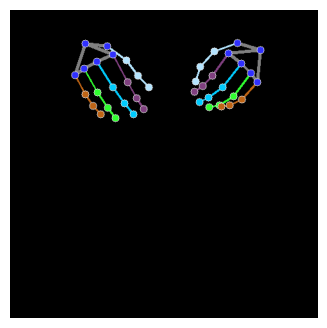

In [17]:
display_video(sample)

## Display a video with both skeleton and raw frame

In [9]:
sample, label = clf_ds.create_segment(idx=0, mode="image_and_skeleton", format=None)

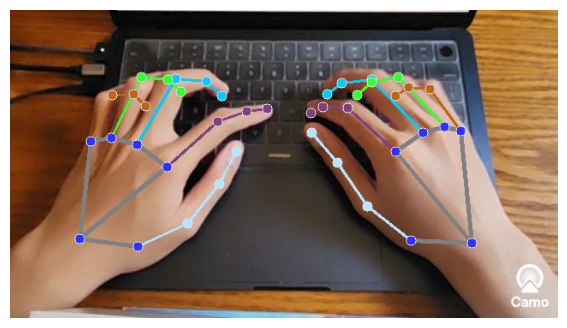

In [10]:
display_video(sample)